In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams['font.family'] = "NanumGothic"
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 데이터 프레임 내 숫자 형태의 string을 int 또는 float으로 변환
def num_str2float(s):
    try:
        return pd.to_numeric(s)
    except ValueError:
        return s

# 데이터 프레임 내 string에서 특정 문자 제거 예: ',' 또는 '_'
def remove_tar_str(s, target_string):
    if isinstance(s, str):
        return s.replace(target_string, '')
    else:
        return s
    
#파일 로드 및 변환
def data_prep(file):
    df = pd.read_csv(file, encoding='utf-8') # 파일 CSV 형태로 로드
    df = df.map(lambda x: remove_tar_str(x, ',')).apply(num_str2float) #데이터 프레임 내 특정 string 제거 후 숫자 변환 수행

    df = df.drop(df.columns[9:], axis=1)
    df['거래금액(원)'] = df['거래금액(만원)']*10000
    df['전용면적(평)'] = df['전용면적(㎡)']/3.3
    df['평단가'] = df['거래금액(만원)']/df['전용면적(평)']
    return df

In [ ]:
file_list = [
    'data/18.csv',
    'data/19.csv',
    'data/20.csv',
    'data/21.csv',
    'data/22.csv',
    'data/23.csv'
]
N_df = pd.DataFrame()
for file in file_list:
    df = data_prep(file)
    N_df = pd.concat([N_df, df], axis=0)

df_desc = N_df.sort_values(by=['계약년월']).groupby('계약년월').agg({'평단가': 'mean'})

In [ ]:
df_desc

In [ ]:
N_df.to_csv("data/18~23.csv", index=True)

In [ ]:
trade_volumn = N_df['계약년월'].value_counts()
trade_volumn

In [ ]:
temp_out_df = pd.merge(df_desc, trade_volumn, left_index=True, right_index=True, how='inner')

In [ ]:
#한국은행 기준 금리 데이터 파일 로드 및 변환
sample_df = pd.read_csv('data/한국은행 기준금리 및 여수신금리_2013_11-2023_11.csv', encoding='utf-8') # 파일 CSV 형태로 로드
sample_df = sample_df.map(lambda x: remove_tar_str(x, ',')).apply(num_str2float) #데이터 프레임 내 특정 string 제거 후 숫자 변환 수행
column_names = sample_df.columns
ref_inter_rate = sample_df.drop(columns=column_names[0:4], axis=1).T.rename(columns={0: "금리"})
ref_inter_rate.index = pd.to_numeric(ref_inter_rate.index.str.replace('/', ''))

In [ ]:
sample_df

In [ ]:
ref_inter_rate

In [ ]:
final_out_df = pd.merge(temp_out_df, ref_inter_rate, how='inner', left_index=True, right_index=True)

In [ ]:
kospi = pd.read_csv('data/kospi.csv',index_col=0)
kosdaq = pd.read_csv('data/kosdaq.csv', index_col=0)
simli_df = pd.read_csv("data/simli.csv", index_col=0)
hwan_df = pd.read_csv('data/hwan.csv', index_col=0)

In [ ]:
temp_df1 = pd.merge(final_out_df, kospi, how='inner', left_index=True, right_index=True)

In [ ]:
temp_df2 = pd.merge(temp_df1, kosdaq, how='inner', left_index=True, right_index=True)

In [ ]:
final_final_df = temp_df2.rename(columns={"count": "volume", "0": "kospi", "1": 'kosdaq'})

In [ ]:
temp_df = pd.merge(final_final_df, simli_df, how='inner', left_index=True, right_index=True)
final_final_df = pd.merge(temp_df, hwan_df, how='inner', left_index=True, right_index=True)
final_final_df.to_csv('data/completed_gangnam.csv')

In [5]:
df = pd.read_csv('data/completed_gangnam.csv', index_col=0)

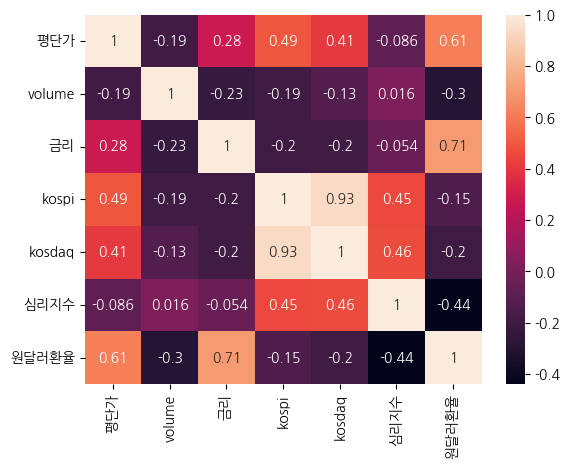

In [30]:
sns.heatmap(df.corr(), annot=True)
plt.show()

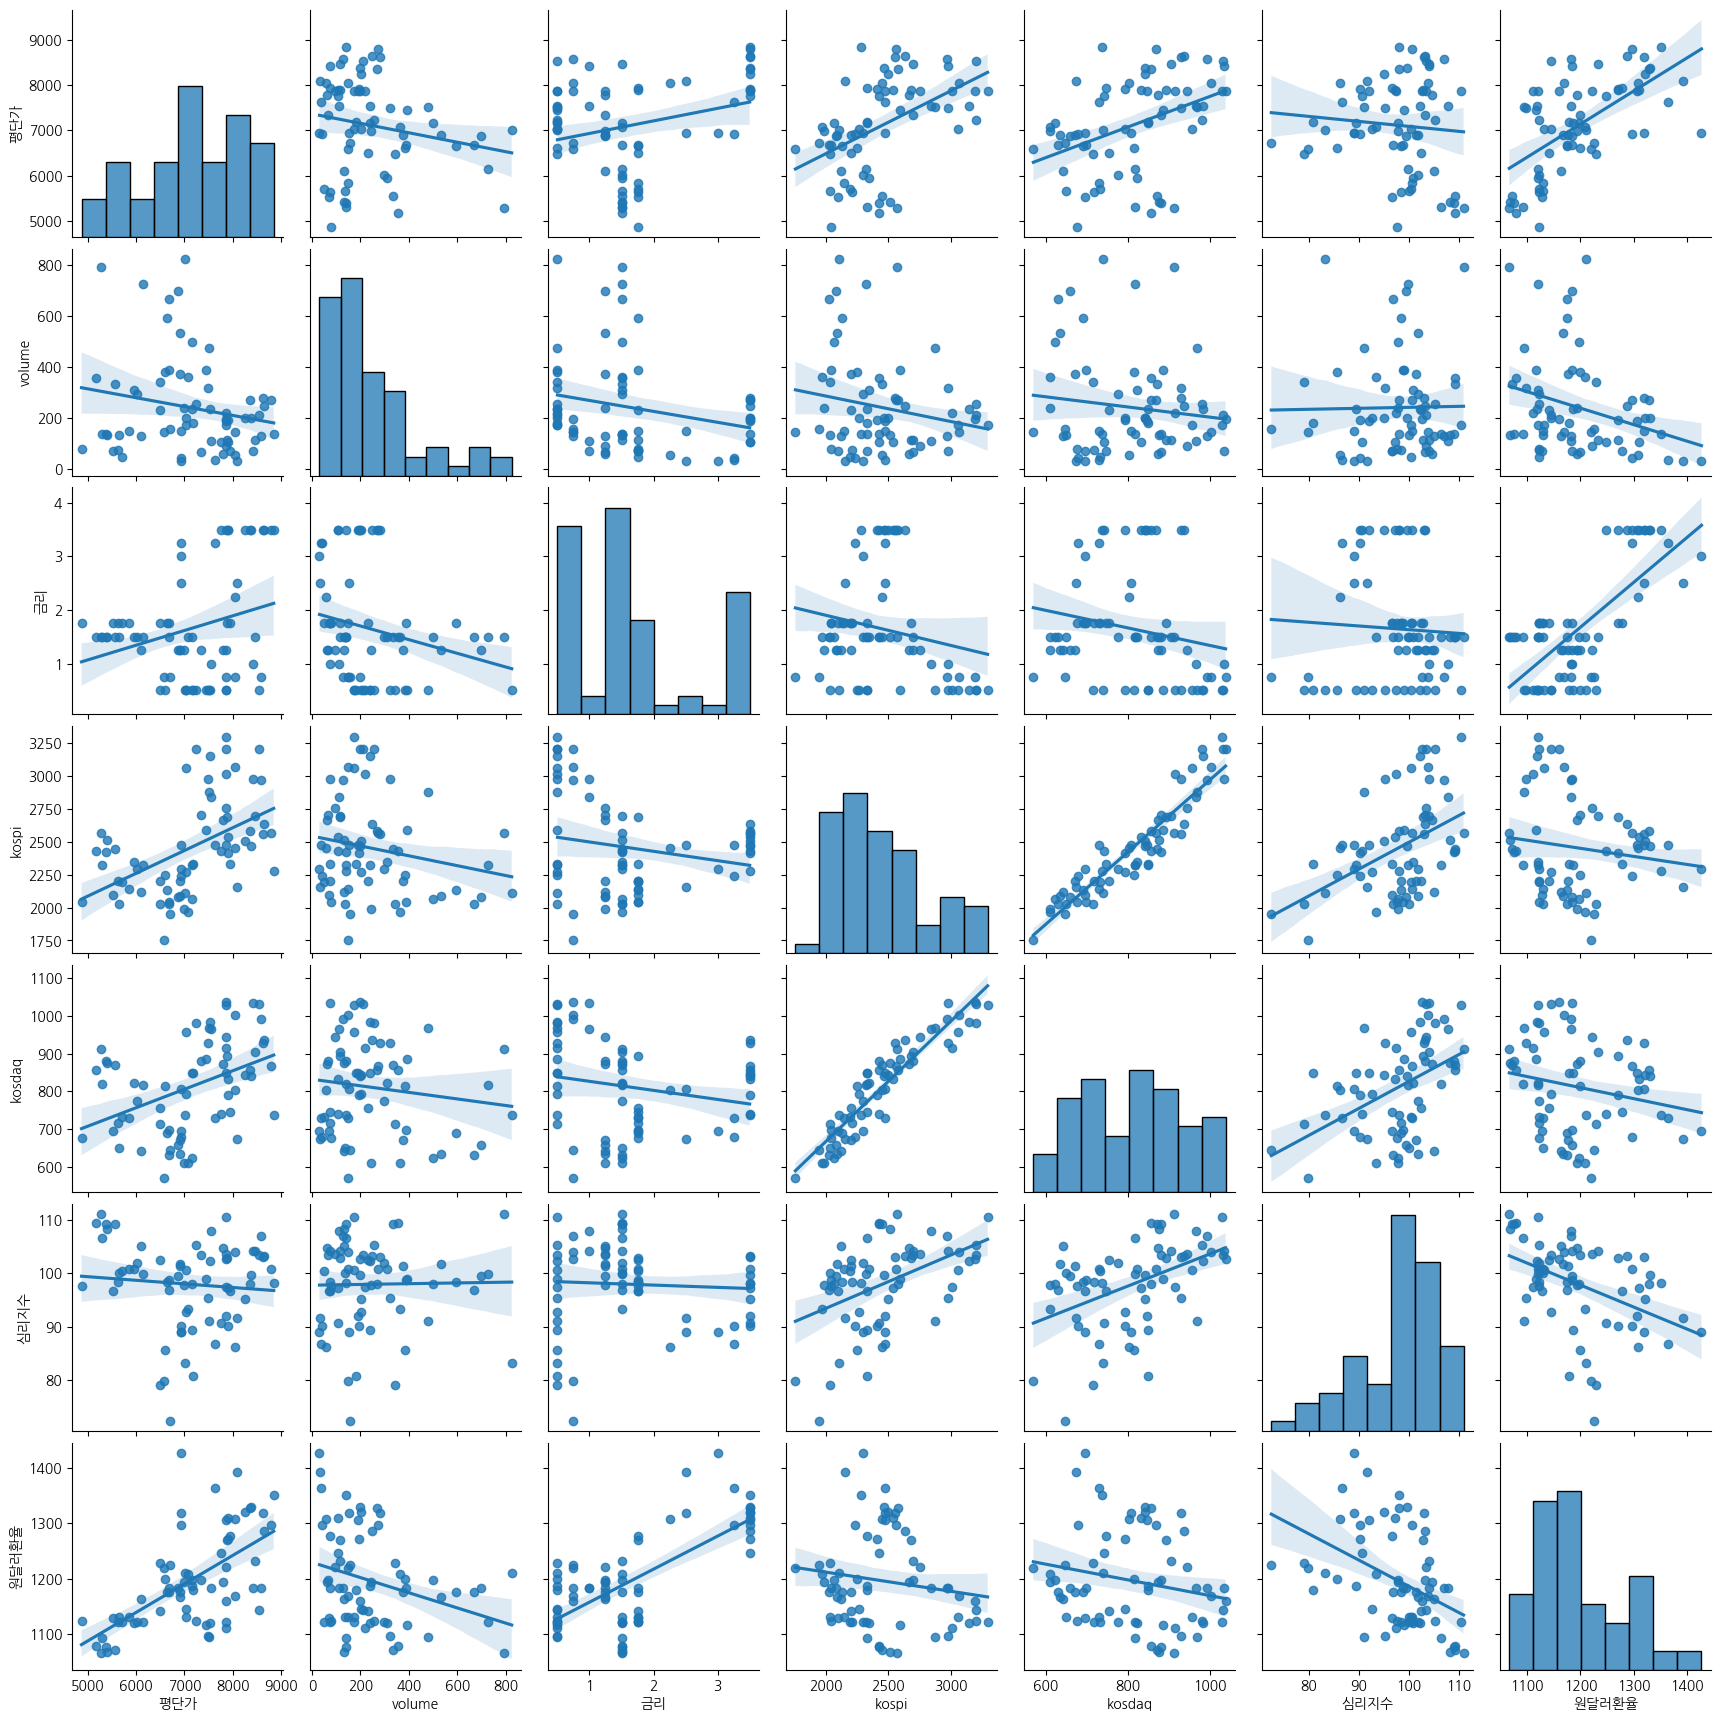

In [46]:

sns.pairplot(df, kind='reg')
